In [3]:
import tensorflow as tf
print("hello")
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.keras.engine import training
print("hello")
import hypar
import network_16 as net
print("hello")

hello
hello
hello


In [4]:
# Model saved with Keras model.save()
MODEL_PATH = 'models/arcface_weights.h5'
cosine_threshold = 0.075	#emperically set threshold

def ResNet34():

	img_input = tf.keras.layers.Input(shape=(112, 112, 3))

	x = tf.keras.layers.ZeroPadding2D(padding=1, name='conv1_pad')(img_input)
	x = tf.keras.layers.Conv2D(64, 3, strides=1, use_bias=False, kernel_initializer='glorot_normal', name='conv1_conv')(x)
	x = tf.keras.layers.BatchNormalization(axis=3, epsilon=2e-5, momentum=0.9, name='conv1_bn')(x)
	x = tf.keras.layers.PReLU(shared_axes=[1, 2], name='conv1_prelu')(x)
	x = stack_fn(x)

	model = training.Model(img_input, x, name='ResNet34')

	return model

def block1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
	bn_axis = 3

	if conv_shortcut:
		shortcut = tf.keras.layers.Conv2D(filters, 1, strides=stride, use_bias=False, kernel_initializer='glorot_normal', name=name + '_0_conv')(x)
		shortcut = tf.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_0_bn')(shortcut)
	else:
		shortcut = x

	x = tf.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_1_bn')(x)
	x = tf.keras.layers.ZeroPadding2D(padding=1, name=name + '_1_pad')(x)
	x = tf.keras.layers.Conv2D(filters, 3, strides=1, kernel_initializer='glorot_normal', use_bias=False, name=name + '_1_conv')(x)
	x = tf.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_2_bn')(x)
	x = tf.keras.layers.PReLU(shared_axes=[1, 2], name=name + '_1_prelu')(x)

	x = tf.keras.layers.ZeroPadding2D(padding=1, name=name + '_2_pad')(x)
	x = tf.keras.layers.Conv2D(filters, kernel_size, strides=stride, kernel_initializer='glorot_normal', use_bias=False, name=name + '_2_conv')(x)
	x = tf.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_3_bn')(x)

	x = tf.keras.layers.Add(name=name + '_add')([shortcut, x])
	return x

def stack1(x, filters, blocks, stride1=2, name=None):
	x = block1(x, filters, stride=stride1, name=name + '_block1')
	for i in range(2, blocks + 1):
		x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
	return x

def stack_fn(x):
	x = stack1(x, 64, 3, name='conv2')
	x = stack1(x, 128, 4, name='conv3')
	x = stack1(x, 256, 6, name='conv4')
	return stack1(x, 512, 3, name='conv5')

def loadModel():
	base_model = ResNet34()
	inputs = base_model.inputs[0]
	arcface_model = base_model.outputs[0]
	arcface_model = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=2e-5)(arcface_model)
	arcface_model = tf.keras.layers.Dropout(0.4)(arcface_model)
	arcface_model = tf.keras.layers.Flatten()(arcface_model)
	arcface_model = tf.keras.layers.Dense(512, activation=None, use_bias=True, kernel_initializer="glorot_normal")(arcface_model)
	embedding = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=2e-5, name="embedding", scale=True)(arcface_model)
	model = tf.keras.models.Model(inputs, embedding, name=base_model.name)
	
	model.load_weights(MODEL_PATH)

	return model

In [5]:
# Load your trained model
model = loadModel()
print("ArcFace expects ",model.layers[0].input_shape[1:]," inputs")
print("and it represents faces as ", model.layers[-1].output_shape[1:]," dimensional vectors")

2022-11-24 08:28:35.171136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 08:28:35.197689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 08:28:35.197877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 08:28:35.198331: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

ArcFace expects  []  inputs
and it represents faces as  (512,)  dimensional vectors


In [6]:
def get_distance(emb1,emb2):
  """
  emb1 & emb2: are both 512 dimensional vectors from the trained resnet model

  get_distance: returns cosine_distance
  """

  a = np.matmul(np.transpose(emb1), emb2)
  b = np.sum(np.multiply(emb1, emb1))
  c = np.sum(np.multiply(emb2, emb2))
  cosine_distance = 1 - (a / (np.sqrt(b) * np.sqrt(c)))

  return cosine_distance


def face_verify(img_path,img_path2,model):
    
    face1x = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if(face1x.shape[2]==4):
      face1 = cv2.cvtColor(face1x, cv2.COLOR_BGRA2RGB)
    else:
      face1 = cv2.cvtColor(face1x, cv2.COLOR_BGR2RGB)
    face2x = cv2.imread(img_path2, cv2.IMREAD_UNCHANGED)
    if(face2x.shape[2]==4):
      face2 = cv2.cvtColor(face2x, cv2.COLOR_BGRA2RGB)
    else:
      face2 = cv2.cvtColor(face2x, cv2.COLOR_BGR2RGB)
    print('Original Dimensions : ',face1.shape)
    plt.imshow(face1)
    plt.show()
    plt.imshow(face2)
    plt.show()
    # resize image
    x1a = cv2.resize(face1, (112,112), interpolation = cv2.INTER_AREA)
    print('Resized Dimensions : ',x1a.shape)
    x1a = net.Resnet_preprocess(x1a)
    img_pixels1 = np.expand_dims(x1a, axis = 0)
    #img_pixels1 /= 255           #normalize input 
    print(img_pixels1.shape)
    x2a = cv2.resize(face2, (112,112), interpolation = cv2.INTER_AREA)
    x2a = net.Resnet_preprocess(x2a)
    img_pixels2 = np.expand_dims(x2a, axis = 0)
    #|img_pixels2 /= 255           #normalize input 
    # Be careful how your trained model deals with the input
    # otherwise, it won't make correct prediction!
    x1 = img_pixels1
    x2 = img_pixels2

    embedding1 = model.predict(x1)
    embedding2 = model.predict(x2)
    preds = "Different People"

    cosine_distance = get_distance(embedding1.T,embedding2.T)
    print(cosine_distance)
    if cosine_distance<cosine_threshold:
        preds = "Same People"

    return preds

In [7]:
# images are stored in the images folder. Change path here to do face verification with different images
img_path1 = 'images/a.jpeg'
img_path2 = 'images/b.jpeg'

Original Dimensions :  (1325, 943, 3)


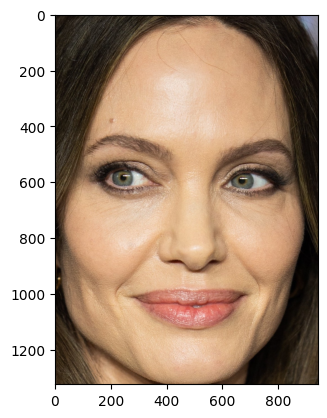

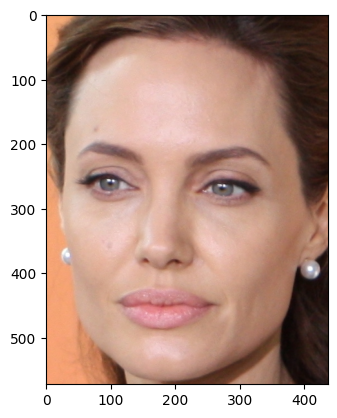

Resized Dimensions :  (112, 112, 3)
(1, 112, 112, 3)


2022-11-24 08:28:45.162636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8201


1/1 [==============================] - 0s 36ms/step
[[0.0723353]]
Same People


2022-11-24 08:28:47.103597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [8]:
pred = face_verify(img_path1,img_path2,model)
print(pred)